# 오디오 분류(Audio Classification)

* 가상 악기를 활용해 악기별 음색 데이터셋을 활용해 오디오 분류

1. 기존 데이터에서 분류에 사용되는 방법을 사용해 분류
2. 오디오 데이터에 특화된 분류

* 출처: https://bab2min.tistory.com/642

### 데이터 준비 및 전처리

In [42]:
import numpy as np
import itertools, librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

* 데이터를 저장할 리스트와 파일을 불러올 경로를 지정

* http://suanlab.com/datasets/GeneralMidi.wav



In [ ]:
!wget http://suanlab.com/datasets/GeneralMidi.wav

In [44]:
midi_file = './GeneralMidi.wav'

* wmv 파일에는 128개 악기와 46개 타악기의 음을 50개씩 2초 간격으로 존재
* 해당 예제에서는 일부 악기만 선택해서 사용

In [45]:
instruments = [i for i in range(0, 100, 10)]
num_notes = 50
sec = 2

audio, inst = [], []
for inst_idx, note in itertools.product(range(len(instruments)), range(num_notes)):
  instrument = instruments[inst_idx]
  offset = (instrument*num_notes*sec) + (note*sec)
  print(f'Instrument : {instrument}, note : {note}, sec : {offset}')
  y, sr = librosa.load(midi_file, sr=None, offset=offset, duration=2.0)
  audio.append(y)
  inst.append(inst_idx)

Instrument : 0, note : 0, sec : 0
Instrument : 0, note : 1, sec : 2
Instrument : 0, note : 2, sec : 4
Instrument : 0, note : 3, sec : 6
Instrument : 0, note : 4, sec : 8
Instrument : 0, note : 5, sec : 10
Instrument : 0, note : 6, sec : 12
Instrument : 0, note : 7, sec : 14
Instrument : 0, note : 8, sec : 16
Instrument : 0, note : 9, sec : 18
Instrument : 0, note : 10, sec : 20
Instrument : 0, note : 11, sec : 22
Instrument : 0, note : 12, sec : 24
Instrument : 0, note : 13, sec : 26
Instrument : 0, note : 14, sec : 28
Instrument : 0, note : 15, sec : 30
Instrument : 0, note : 16, sec : 32
Instrument : 0, note : 17, sec : 34
Instrument : 0, note : 18, sec : 36
Instrument : 0, note : 19, sec : 38
Instrument : 0, note : 20, sec : 40
Instrument : 0, note : 21, sec : 42
Instrument : 0, note : 22, sec : 44
Instrument : 0, note : 23, sec : 46
Instrument : 0, note : 24, sec : 48
Instrument : 0, note : 25, sec : 50
Instrument : 0, note : 26, sec : 52
Instrument : 0, note : 27, sec : 54
Instrum

In [46]:
audio_np = np.array(audio, np.float32)
inst_np = np.array(inst, np.int16)

print(audio_np.shape, inst_np.shape)

(500, 88200) (500,)


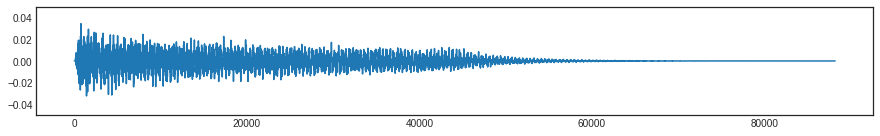

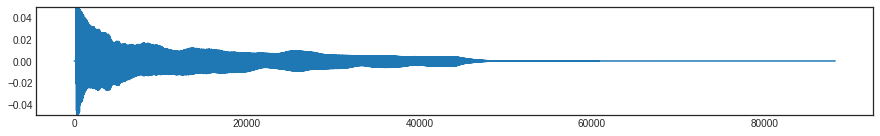

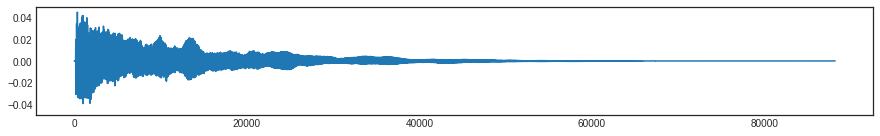

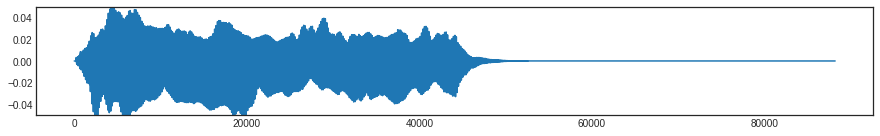

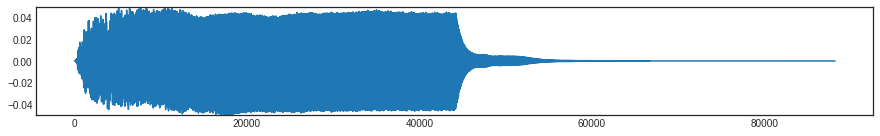

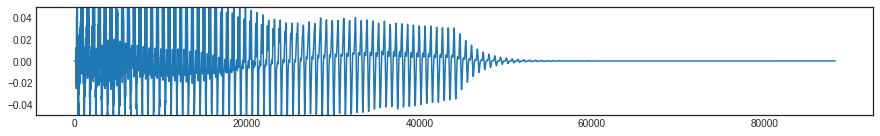

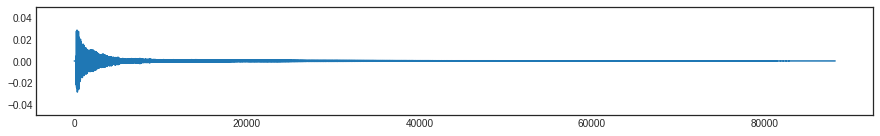

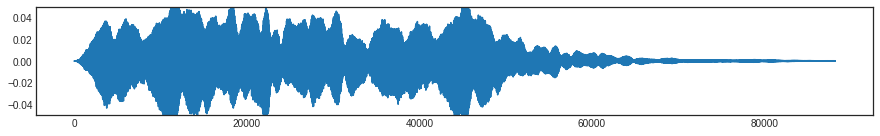

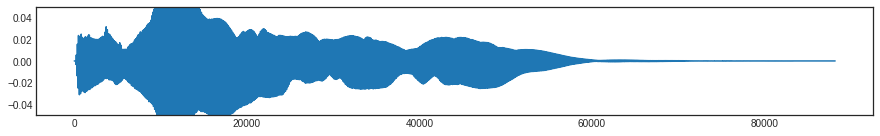

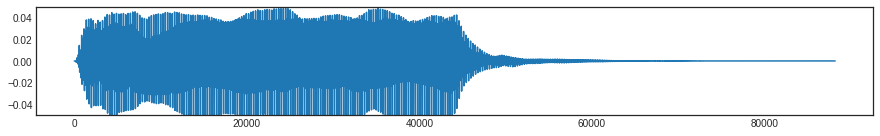

In [47]:
for i in range(0, len(audio_np), num_notes):
  plt.figure(figsize=(15,2))
  plt.plot(audio_np[i])
  plt.ylim((-0.05, 0.05));

In [48]:
print(inst_np[0])
ipd.Audio(audio_np[0], rate=sr)

0


In [49]:
print(inst_np[50])
ipd.Audio(audio_np[50], rate=sr)

1


In [50]:
print(inst_np[100])
ipd.Audio(audio_np[100], rate=sr)

2


In [51]:
print(inst_np[150])
ipd.Audio(audio_np[150], rate=sr)

3


In [52]:
print(inst_np[200])
ipd.Audio(audio_np[200], rate=sr)

4


In [53]:
print(inst_np[250])
ipd.Audio(audio_np[250], rate=sr)

5


In [54]:
print(inst_np[300])
ipd.Audio(audio_np[300], rate=sr)

6


In [55]:
print(inst_np[350])
ipd.Audio(audio_np[350], rate=sr)

7


In [56]:
print(inst_np[400])
ipd.Audio(audio_np[400], rate=sr)

8


In [57]:
print(inst_np[450])
ipd.Audio(audio_np[450], rate=sr)

9


In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(audio_np)

MinMaxScaler()

## 머신러닝을 이용한 오디오 분류

* 학습 데이터와 실험 데이터를 분리

In [59]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(audio_np, inst_np, test_size=0.2)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(400, 88200) (400,)
(100, 88200) (100,)


### Logistic Regression

* Logistic Regression은 특성상 다중 분류에는 적합하지 않음

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(x_train, y_train)

pred = lr.predict(x_test)
acc = accuracy_score(pred, y_test)

print(acc)

0.07


### Support Vector Machine

In [61]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(x_train, y_train)

pred = SVM.predict(x_test)
acc = accuracy_score(pred, y_test)

print(acc)

0.1


### Decision Tree

In [62]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

pred = dt.predict(x_test)
acc = accuracy_score(pred, y_test)

print(acc)

0.32


## Constant-Q를 이용한 머신러닝 오디오 분류

### 데이터 준비

* wav는 매 순간의 음압을 측정하여 그 수치를 저장한 형태이기 때문에 그 자체로 음악을 분석하기에 적합하지 않음  
(음의 높이와 세기를 듣는것이지 순간의 음압을 듣는게 아니기 때문)
* 푸리에 변환과 같은 변환 기법을 이용하여 시간 축의 데이터를 주파수 축의 데이터로 바꿔줘야할 필요가 있음
* 푸리에 변환 대신 푸리에 변환과 유사한 Constant-Q 변환을 사용
* Constant-Q 변환은 주파수 축이 로그 단위로 변환되고,  
각 주파수에 따라 해상도가 다양하게 처리되기 때문에(저주파는 저해상도, 고주파는 고해상도)  
음악을 처리하는 데에 푸리에 변환보다 유리

*   주파수 대역을 저장할 리스트 `audio_cqt` 선언
*   constant-Q 변환할 때는 변환할 오디오 데이터와 sampling rate가 필요
*   해당 데이터에서는 sampling rate가 모두 동일하므로 따로 처리가 필요하지 않음
*   여기서는 Constant-Q 변환을 사용해 오디오 데이터를 주파수 대역으로 변환




*   변환에는 앞서 준비한 데이터를 가져와 사용하며, Constant-Q 변환에는 `librosa.cqt` 함수를 사용
*   여기서 `n_bins`는 옥타브 단계 및 개수를, `bins_per_octave`는 한 옥타브가 가지는 단계를 의미
*   라벨에 대해선 원 핫 인코딩을 적용



In [63]:
audio_cqt = []

for i in audio:
  ret = librosa.cqt(i, sr, hop_length=1024, n_bins=24*7, bins_per_octave=24)   #Compute the constant-Q transform of an audio signal
  ret = np.abs(ret)
  audio_cqt.append(ret)

* 앞서 생성한 주파수 대역을 spectrogram으로 시각화
* 악기 간 spectrogram을 비교해보면 차이가 존재함을 알 수 있음

In [68]:
len(audio_cqt), audio_cqt[0].shape

(500, (168, 87))

/usr/local/lib/python3.8/dist-packages/librosa/display.py:1335: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  warnings.warn(


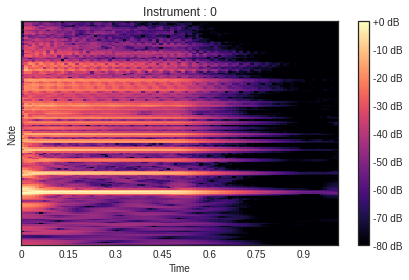

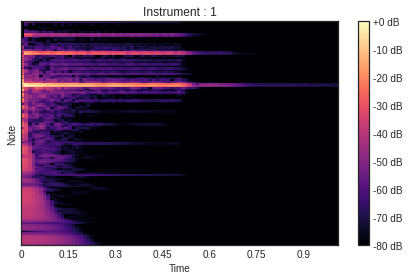

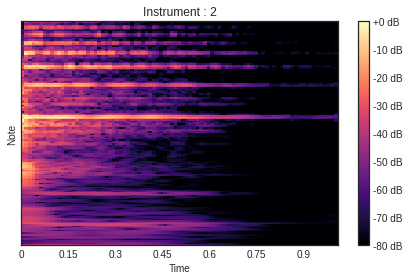

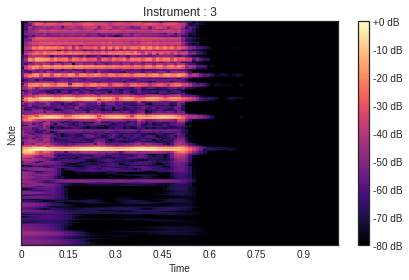

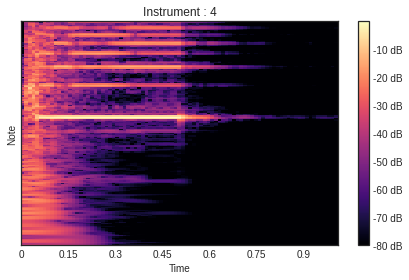

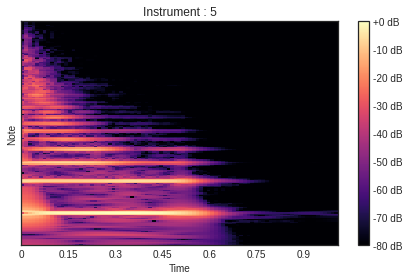

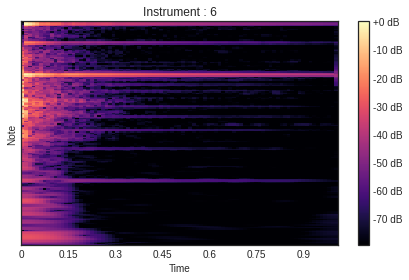

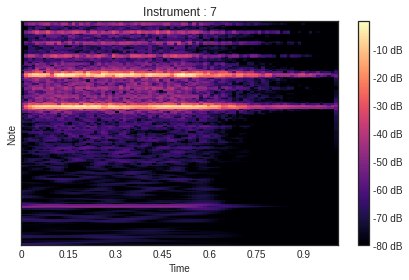

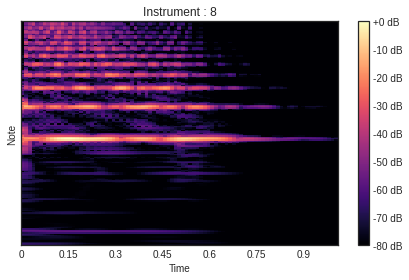

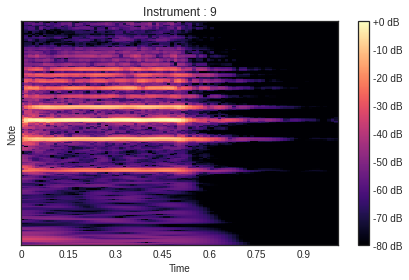

In [69]:
for i in range(0, len(instruments)*num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_cqt[i]), ref=np.max)
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'Instrument : {inst[i]}')
  plt.tight_layout()
  plt.show()

* 훈련 데이터와 실험 데이터를 분리

In [70]:
cqt_np = np.array(audio_cqt, np.float32)
inst_np = np.array(inst, np.int16)

print(cqt_np.shape, inst_np.shape)

(500, 168, 87) (500,)




*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [73]:
cqt_np = cqt_np.reshape(500, -1)

print(cqt_np.shape)

(500, 14616)




*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [74]:
scaler = MinMaxScaler()
scaler.fit(cqt_np)

MinMaxScaler()

* 학습 데이터와 실험 데이터를 분리

In [77]:
x_train, x_test, y_train, y_test = train_test_split(cqt_np, inst_np, test_size=0.2)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(400, 14616) (400,)
(100, 14616) (100,)


### Logistic Regression

In [78]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

pred = lr.predict(x_test)
acc = accuracy_score(pred, y_test)

print(acc)

0.24


### Support Vector Machine

In [79]:
SVM = svm.SVC(kernel='linear')
SVM.fit(x_train, y_train)

pred = SVM.predict(x_test)
acc = accuracy_score(pred, y_test)

print(acc)

0.29


### Decision Tree

In [80]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

pred = dt.predict(x_test)
acc = accuracy_score(pred, y_test)

print(acc)

0.6


## Constant-Q 특징을 이용한 딥러닝 오디오 분류

* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [86]:
from keras.utils import to_categorical

cqt_np = np.array(audio_cqt, np.float32)   #(500, 168, 87)
cqt_np = cqt_np.reshape(500, -1)           #(500, 14616)
cqt_array = np.expand_dims(cqt_np, -1)     #(500, 14616, 1)

inst_cat = to_categorical(inst_np)         #(500, 10)

x_train, x_test, y_train, y_test = train_test_split(cqt_array, inst_cat, test_size=0.2)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(400, 14616, 1) (400, 10)
(100, 14616, 1) (100, 10)


In [92]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense

def build_model():
  model = Sequential()

  input = Input(shape=(14616,), name='input')
  output = Dense(512, activation='relu', name='hidden1')(input)
  output = Dense(256, activation='relu', name='hidden2')(output)
  output = Dense(128, activation='relu', name='hidden3')(output)
  output = Dense(10, activation='softmax', name='output')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

  return model

In [93]:
model = build_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 14616)]           0         
                                                                 
 hidden1 (Dense)             (None, 512)               7483904   
                                                                 
 hidden2 (Dense)             (None, 256)               131328    
                                                                 
 hidden3 (Dense)             (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 7,649,418
Trainable params: 7,649,418
Non-trainable params: 0
_________________________________________________________________


In [94]:
history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 2s 225ms/step - loss: 2.2243 - acc: 0.1406 - val_loss: 2.0972 - val_acc: 0.2000
Epoch 2/30
3/3 [==============================] - 0s 116ms/step - loss: 1.8317 - acc: 0.4219 - val_loss: 1.8407 - val_acc: 0.3125
Epoch 3/30
3/3 [==============================] - 0s 112ms/step - loss: 1.4791 - acc: 0.5312 - val_loss: 1.6721 - val_acc: 0.3250
Epoch 4/30
3/3 [==============================] - 0s 113ms/step - loss: 1.2030 - acc: 0.6281 - val_loss: 1.6020 - val_acc: 0.3625
Epoch 5/30
3/3 [==============================] - 0s 113ms/step - loss: 0.9661 - acc: 0.7563 - val_loss: 1.6596 - val_acc: 0.3875
Epoch 6/30
3/3 [==============================] - 0s 117ms/step - loss: 0.7685 - acc: 0.7969 - val_loss: 1.7630 - val_acc: 0.4125
Epoch 7/30
3/3 [==============================] - 0s 121ms/step - loss: 0.6151 - acc: 0.8188 - val_loss: 1.8420 - val_acc: 0.4375
Epoch 8/30
3/3 [==============================] - 0s 115ms/step - loss: 0.4921 - acc: 0.83

[]

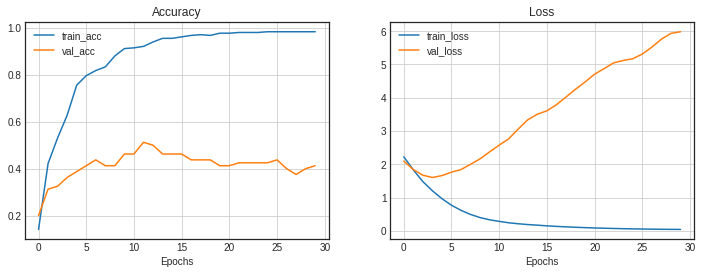

In [107]:
fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['acc'], label='train_acc')
ax1.plot(history.history['val_acc'], label='val_acc')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend()
ax1.grid()

ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['loss'], label='train_loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epochs')
ax2.legend()
ax2.grid()
plt.plot()

In [108]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 51ms/step - loss: 5.3220 - acc: 0.4200


[5.322038650512695, 0.41999998688697815]

### CNN 모델 구성



*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [109]:
cqt_np = np.array(audio_cqt, np.float32)    #(500, 168, 87)
cqt_array = np.expand_dims(cqt_np, -1)      #(500, 168, 87, 1)

inst_cat = to_categorical(inst_np)          #(500, 10)

x_train, x_test, y_train, y_test = train_test_split(cqt_array, inst_cat, test_size=0.2)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(400, 168, 87, 1) (400, 10)
(100, 168, 87, 1) (100, 10)


In [113]:
from keras.layers import Conv2D, MaxPool2D, Flatten

def build_model():
  model = Sequential()

  input = Input(shape=(168, 87, 1))

  output = Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)

  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

  return model

In [114]:
model = build_model()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 168, 87, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 168, 87, 128)      1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 44, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 44, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 22, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 42, 22, 512)       1180

In [115]:
history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 130s 40s/step - loss: 2.2213 - acc: 0.1500 - val_loss: 2.0595 - val_acc: 0.2375
Epoch 2/30
3/3 [==============================] - 136s 40s/step - loss: 1.8364 - acc: 0.3594 - val_loss: 1.8334 - val_acc: 0.2875
Epoch 3/30
3/3 [==============================] - 111s 36s/step - loss: 1.4974 - acc: 0.4563 - val_loss: 1.4242 - val_acc: 0.4000
Epoch 4/30
3/3 [==============================] - 128s 35s/step - loss: 0.9748 - acc: 0.6344 - val_loss: 1.2301 - val_acc: 0.6000
Epoch 5/30
3/3 [==============================] - 105s 30s/step - loss: 0.6493 - acc: 0.7906 - val_loss: 1.3074 - val_acc: 0.7000
Epoch 6/30
3/3 [==============================] - 115s 39s/step - loss: 0.5092 - acc: 0.8000 - val_loss: 1.1764 - val_acc: 0.7500
Epoch 7/30
3/3 [==============================] - 99s 31s/step - loss: 0.4339 - acc: 0.8687 - val_loss: 1.2146 - val_acc: 0.8000
Epoch 8/30
3/3 [==============================] - 96s 30s/step - loss: 0.4429 - acc: 0.8813

[]

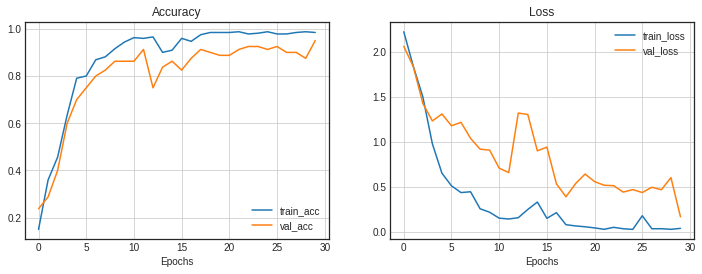

In [116]:
fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['acc'], label='train_acc')
ax1.plot(history.history['val_acc'], label='val_acc')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend()
ax1.grid()

ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['loss'], label='train_loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epochs')
ax2.legend()
ax2.grid()
plt.plot()



*   훈련한 모델에 대한 정확도 평가
*   앞선 일반 분류 방법보다 정확도가 많이 오른 것을 확인할 수 있음



In [117]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 9s 2s/step - loss: 0.2481 - acc: 0.9000


[0.24808482825756073, 0.8999999761581421]

## MFCC를 이용한 머신러닝 오디오 분류

### 데이터 준비

* 데이터를 불러오고 MFCC(Mel-frequency cepstral coefficients)를 사용해 melspectrogram으로 변환

In [118]:
audio_mfcc = []
for i in audio:
  ret = librosa.feature.mfcc(y=i, sr=sr)
  audio_mfcc.append(ret)

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9839 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9839 missing from current font.
  font.set_text(s, 0, flags=flags)


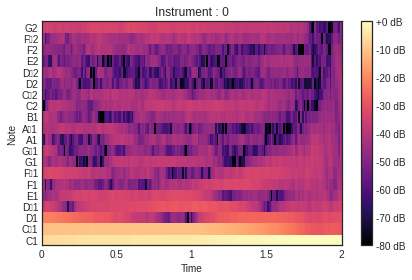

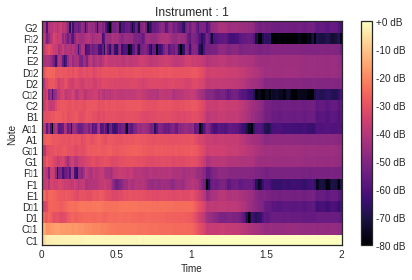

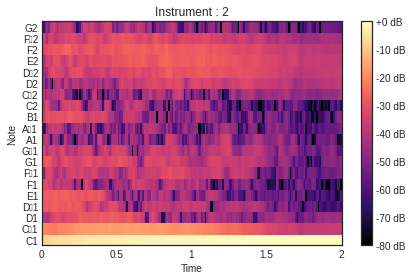

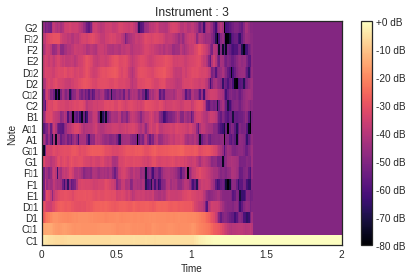

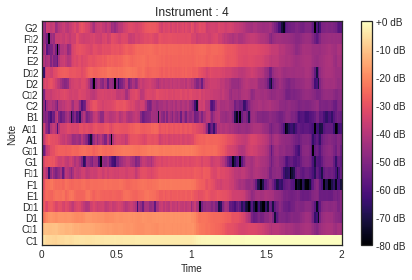

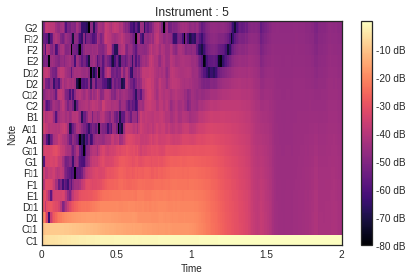

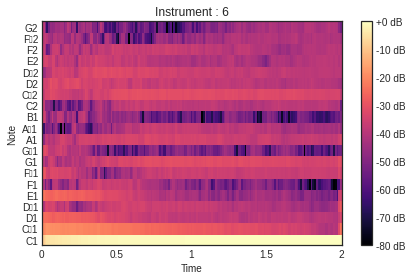

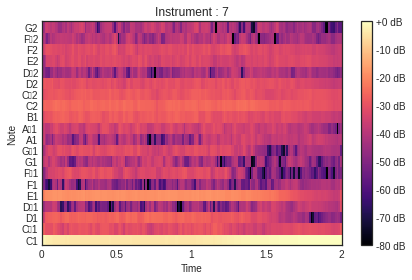

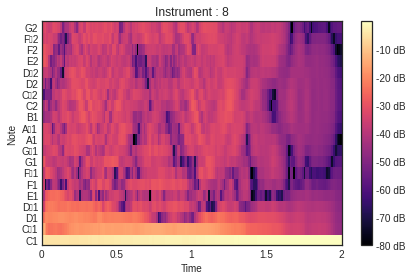

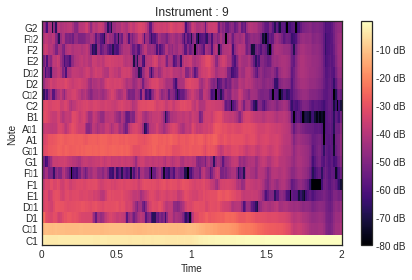

In [119]:
for i in range(0, len(instruments)*num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_mfcc[i]), ref=np.max)
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'Instrument : {inst[i]}')
  plt.tight_layout()
  plt.show()

In [120]:
mfcc_np = np.array(audio_mfcc, np.float32)
inst_np = np.array(inst, np.int16)

print(mfcc_np.shape, inst_np.shape)

(500, 20, 173) (500,)




*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [121]:
mfcc_np = mfcc_np.reshape(500, -1)

print(mfcc_np.shape)

(500, 3460)




*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [122]:
scaler = MinMaxScaler()
scaler.fit(mfcc_np)

MinMaxScaler()

* 학습 데이터와 실험 데이터를 분리

In [123]:
x_train, x_test, y_train, y_test = train_test_split(mfcc_np, inst_np, test_size=0.2)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(400, 3460) (400,)
(100, 3460) (100,)


### Logistic Regression

In [124]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

pred = lr.predict(x_test)
acc = accuracy_score(pred, y_test)

print(acc)

0.96


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Support Vector Machine

In [125]:
SVM = svm.SVC(kernel='linear')
SVM.fit(x_train, y_train)

pred = SVM.predict(x_test)
acc = accuracy_score(pred, y_test)

print(acc)

0.97


### Decision Tree

In [126]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

pred = dt.predict(x_test)
acc = accuracy_score(pred, y_test)

print(acc)

0.88


## MFCC를 이용한 딥러닝 오디오 분류

* 앞선 문제점을 극복하기 위해 오디오 데이터에 특화된 분류 방법 필요
* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [127]:
from keras.utils import to_categorical

mfcc_np = np.array(audio_mfcc, np.float32)   #(500, 168, 87)
mfcc_np = mfcc_np.reshape(500, -1)           #(500, 14616)
mfcc_array = np.expand_dims(mfcc_np, -1)     #(500, 14616, 1)

inst_cat = to_categorical(inst_np)         #(500, 10)

x_train, x_test, y_train, y_test = train_test_split(mfcc_array, inst_cat, test_size=0.2)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(400, 3460, 1) (400, 10)
(100, 3460, 1) (100, 10)


In [130]:
def build_model():
  model = Sequential()

  input = Input(shape=(3460,), name='input')
  output = Dense(512, activation='relu', name='hidden1')(input)
  output = Dense(256, activation='relu', name='hidden2')(output)
  output = Dense(128, activation='relu', name='hidden3')(output)
  output = Dense(10, activation='softmax', name='output')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

  return model

In [131]:
model = build_model()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 3460)]            0         
                                                                 
 hidden1 (Dense)             (None, 512)               1772032   
                                                                 
 hidden2 (Dense)             (None, 256)               131328    
                                                                 
 hidden3 (Dense)             (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1,937,546
Trainable params: 1,937,546
Non-trainable params: 0
_________________________________________________________________


In [132]:
history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 1s 152ms/step - loss: 237.7422 - acc: 0.1125 - val_loss: 344.0857 - val_acc: 0.1125
Epoch 2/30
3/3 [==============================] - 0s 44ms/step - loss: 274.4060 - acc: 0.1063 - val_loss: 162.4381 - val_acc: 0.1750
Epoch 3/30
3/3 [==============================] - 0s 51ms/step - loss: 126.5913 - acc: 0.2438 - val_loss: 132.2953 - val_acc: 0.1000
Epoch 4/30
3/3 [==============================] - 0s 43ms/step - loss: 85.3370 - acc: 0.2062 - val_loss: 57.7380 - val_acc: 0.3875
Epoch 5/30
3/3 [==============================] - 0s 45ms/step - loss: 45.3783 - acc: 0.3469 - val_loss: 32.4226 - val_acc: 0.2750
Epoch 6/30
3/3 [==============================] - 0s 45ms/step - loss: 22.2440 - acc: 0.4625 - val_loss: 26.4243 - val_acc: 0.4500
Epoch 7/30
3/3 [==============================] - 0s 47ms/step - loss: 21.7683 - acc: 0.4563 - val_loss: 23.5870 - val_acc: 0.4375
Epoch 8/30
3/3 [==============================] - 0s 51ms/step - loss: 12.86

[]

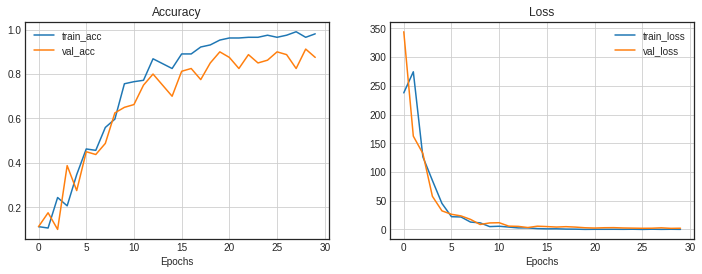

In [133]:
fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['acc'], label='train_acc')
ax1.plot(history.history['val_acc'], label='val_acc')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend()
ax1.grid()

ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['loss'], label='train_loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epochs')
ax2.legend()
ax2.grid()
plt.plot()

In [134]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 8ms/step - loss: 2.0474 - acc: 0.8800


[2.0473525524139404, 0.8799999952316284]

### CNN 모델 구성

In [135]:
mfcc_np = np.array(audio_mfcc, np.float32)    #(500, 20, 173)
mfcc_array = np.expand_dims(mfcc_np, -1)      #(500, 20, 173, 1)

inst_cat = to_categorical(inst_np)            #(500, 10)

x_train, x_test, y_train, y_test = train_test_split(mfcc_array, inst_cat, test_size=0.2)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(400, 20, 173, 1) (400, 10)
(100, 20, 173, 1) (100, 10)




*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [138]:
def build_model():
  model = Sequential()

  input = Input(shape=(20, 173, 1))

  output = Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(filters=512, kernel_size=(3,3), strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)

  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

  return model

In [139]:
model = build_model()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 173, 1)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 173, 128)      1280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 87, 128)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 87, 256)       295168    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 44, 256)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 44, 512)        1180

In [140]:
history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 29s 9s/step - loss: 45.9208 - acc: 0.1656 - val_loss: 37.2463 - val_acc: 0.0875
Epoch 2/30
3/3 [==============================] - 28s 9s/step - loss: 22.3414 - acc: 0.1187 - val_loss: 2.7598 - val_acc: 0.1000
Epoch 3/30
3/3 [==============================] - 25s 8s/step - loss: 2.4678 - acc: 0.1094 - val_loss: 2.2831 - val_acc: 0.1000
Epoch 4/30
3/3 [==============================] - 25s 8s/step - loss: 2.2446 - acc: 0.1250 - val_loss: 2.1517 - val_acc: 0.1250
Epoch 5/30
3/3 [==============================] - 25s 8s/step - loss: 2.0229 - acc: 0.2500 - val_loss: 1.8185 - val_acc: 0.3000
Epoch 6/30
3/3 [==============================] - 25s 8s/step - loss: 1.6586 - acc: 0.3281 - val_loss: 1.9301 - val_acc: 0.2375
Epoch 7/30
3/3 [==============================] - 25s 8s/step - loss: 1.5906 - acc: 0.3969 - val_loss: 1.2316 - val_acc: 0.5625
Epoch 8/30
3/3 [==============================] - 25s 8s/step - loss: 1.1446 - acc: 0.5938 - val_loss

[]

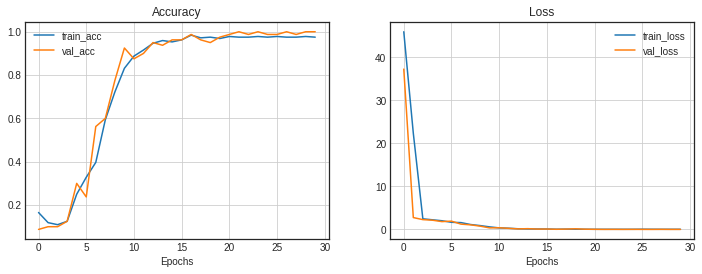

In [142]:
fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['acc'], label='train_acc')
ax1.plot(history.history['val_acc'], label='val_acc')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend()
ax1.grid()

ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['loss'], label='train_loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epochs')
ax2.legend()
ax2.grid()
plt.plot()

In [141]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 2s 463ms/step - loss: 0.0783 - acc: 0.9600


[0.0783267393708229, 0.9599999785423279]